# Can people have extreme personalities?
For ages, the human mind and behavior have been of interest of many scientists. The whole discipline of psychology is based on gathering scientific evidence to explain our behavior. One of the many classifications derived from psychology include different personality traits. Among different frameworks, the **Big 5** is the most commonly used model for personality. But what is the Big 5?

![By Original: Anna Tunikova for peats.de and wikipedia Vector: EssensStrassen - https://peats.de/article/big-five-die-personlichkeit-in-funf-dimensionen, CC BY 4.0, https://commons.wikimedia.org/w/index.php?curid=113609961](img/big5.png){width=300}

The Big 5 consist of the 5 personality traits described in the above image. In this blog, we will explore some of the extremes within this data. Is it possible for a person to score 0 on agreeableness? Or in neuroticism? To answer this questions, we will use public data from [Open Source Psychometrics Project](https://openpsychometrics.org/_rawdata/). This data was collected through personality tests taken on their website.

Let's start by loading the necessary packages and data to conduct our analysis.


In [1]:
# Loading packages
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'jupyterlab'
from IPython.display import display

In [2]:
# Loading data
big5_df = pd.read_csv('data/openpsych_data.csv', sep='\t')
big5_df.columns

Index(['race', 'age', 'engnat', 'gender', 'hand', 'source', 'country', 'E1',
       'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'N1', 'N2', 'N3',
       'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'A1', 'A2', 'A3', 'A4', 'A5',
       'A6', 'A7', 'A8', 'A9', 'A10', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7',
       'C8', 'C9', 'C10', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'O9',
       'O10'],
      dtype='str')

As we can see, the data has a lot of columns that might be useful for our analysis. The first few columns are demographic and include characteristics like race, age, and gender. The latter columns correspond to the data regarding the questions that are part of the personality test. The first letter corresponds to the personality trait, e.g. E=Extraversion, and it is followed by the number of question. Each personality trait has 10 questions. If we refer to the [codebook](https://ipip.ori.org/new_ipip-50-item-scale.htm) used in Open Psychometrics, different questions must be coded differently since some of them are negatively presented. Then, we must prepare the data so we can extract as much of the relevant information as we want.

## Data Preparation

### Demographic data
We will start by making sure that our demographic data is consistent and useful. Starting with race, we will map the numerical coding to the categories that they represent.

In [3]:
# Defining the coding scheme
race_values = '''1=Mixed Race, 2=Arctic (Siberian, Eskimo), 3=Caucasian (European), 
4=Caucasian (Indian), 5=Caucasian (Middle East), 6=Caucasian (North African, Other), 
7=Indigenous Australian, 8=Native American, 
9=North East Asian (Mongol, Tibetan, Korean Japanese, etc), 
10=Pacific (Polynesian, Micronesian, etc), 
11=South East Asian (Chinese, Thai, Malay, Filipino, etc), 12=West African, Bushmen, Ethiopian, 13=Other, 0=missed
'''

parts = re.split(r'(?:,\s+)?([0-9]+)=', race_values.strip())

race_keys = [int(key_val) for key_val in parts[1::2]]
race_values = parts[2::2]
# mapping the numerical order to the nominal categories
race_mapping = dict(zip(race_keys,race_values))
race_mapping
# Assigning its own column to the nominal categories in the dataset
big5_df=big5_df.assign(race_cat=big5_df['race'].map(race_mapping))

In the same way, we can map the numerical coding of gender to the categories they represent.

In [4]:
# Mapping numerical to nominal categories
gender_map = {
    0: pd.NA,
    1: 'male',
    2: 'female',
    3: 'other'
}
# Assigning its own column to the nominal categories in the data
big5_df=big5_df.assign(gender_cat=big5_df['gender'].map(gender_map))

### Coding Questions
We can start by obtaining the questions that represent each of our datapoints in the dataset.

In [5]:
# mapping the questions
questions = '''
E1	I am the life of the party.
E2	I don't talk a lot.
E3	I feel comfortable around people.
E4	I keep in the background.
E5	I start conversations.
E6	I have little to say.
E7	I talk to a lot of different people at parties.
E8	I don't like to draw attention to myself.
E9	I don't mind being the center of attention.
E10	I am quiet around strangers.
N1	I get stressed out easily.
N2	I am relaxed most of the time.
N3	I worry about things.
N4	I seldom feel blue.
N5	I am easily disturbed.
N6	I get upset easily.
N7	I change my mood a lot.
N8	I have frequent mood swings.
N9	I get irritated easily.
N10	I often feel blue.
A1	I feel little concern for others.
A2	I am interested in people.
A3	I insult people.
A4	I sympathize with others' feelings.
A5	I am not interested in other people's problems.
A6	I have a soft heart.
A7	I am not really interested in others.
A8	I take time out for others.
A9	I feel others' emotions.
A10	I make people feel at ease.
C1	I am always prepared.
C2	I leave my belongings around.
C3	I pay attention to details.
C4	I make a mess of things.
C5	I get chores done right away.
C6	I often forget to put things back in their proper place.
C7	I like order.
C8	I shirk my duties.
C9	I follow a schedule.
C10	I am exacting in my work.
O1	I have a rich vocabulary.
O2	I have difficulty understanding abstract ideas.
O3	I have a vivid imagination.
O4	I am not interested in abstract ideas.
O5	I have excellent ideas.
O6	I do not have a good imagination.
O7	I am quick to understand things.
O8	I use difficult words.
O9	I spend time reflecting on things.
O10	I am full of ideas.
'''
# storing them in a dataset
big5_questions_df = pd.DataFrame([item.split('\t') for item in questions.splitlines() if item>''])

Now, it is time to take the direction of the questions into account so we can obtain an accurate total for each of the participant's traits.

In [6]:
# mapping the factors
factor_map = { 1: 'E', 
               2: 'A',
               3: 'C',
               4: 'N',
               5: 'O' }
ipip_df = pd.read_html('big5_questions.html', header=0)[0]
ipip_df = ipip_df.rename(columns={'Unnamed: 1': 'text', 'Unnamed: 7': 'factor_and_direction'})[['text','factor_and_direction']]
ipip_df[['factor','direction']]=ipip_df['factor_and_direction'].str.extract(r'([1-5])(.)')
ipip_df['category']=ipip_df['factor'].astype(int).map(factor_map)
ipip_df = ipip_df.assign(number=np.repeat(np.arange(1,11),5))
ipip_df = ipip_df.assign(qcode=ipip_df['category'].str.cat(ipip_df['number'].astype(str)))  

In [7]:
# differentiating which items are coded negatively
neg_items = ipip_df.query('direction=="-"')['qcode']

# make a copy of the original dataframe for safety
big5_scored_df = big5_df.copy()

# Reverse code the negative items
big5_scored_df[neg_items] = 6-big5_df[neg_items]

In [8]:
# Group the questions into their respective traits
cat_cols = {
    cat : [f'{cat}{n+1}' for n in range(10)] 
    for cat in ('O','C','E','A','N') 
}
# Create a column to store the total score for each trait
for cat, cols in cat_cols.items():
    big5_scored_df[cat]=big5_scored_df[cols].sum(axis=1)

After doing the proper coding, we can see that our dataset now includes a total score in each trait for each of the participants.

In [9]:
#Showing the top cells of the current dataframe
big5_scored_df[['O','C','E','A','N']].head(5)

,O,C,E,A,N
0,43,47,44,46,49
1,26,42,22,35,29
2,45,49,35,38,14
3,41,26,22,37,17
4,34,34,34,44,30


## Analysis
After we have treated our data in a way that is useful to us, we can start doing some analysis to answer our guiding questions. Once we have the column of total scores for each personality traits, we can see the distribution of the scores to get a sense of how the distribution among the sample. 

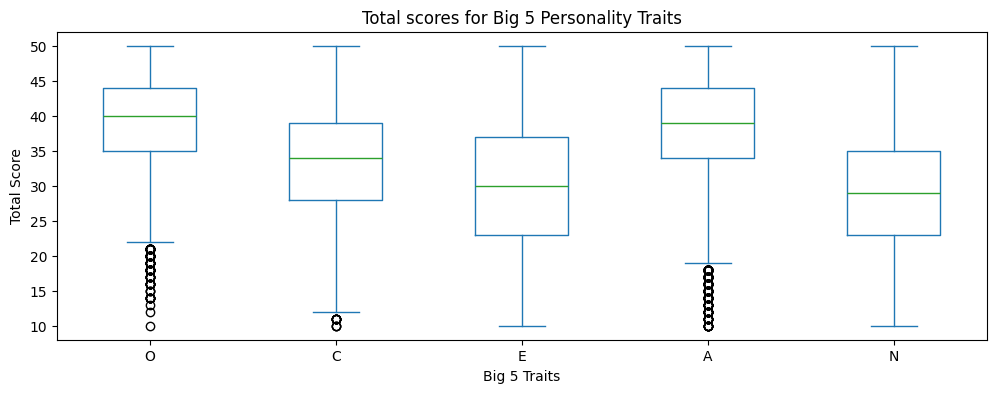

In [10]:
# Creating a boxplot of the distribution of scores of the 5 traits
big5_scored_df.plot(
                    kind='box', 
                    column=['O','C','E','A','N'], 
                    figsize=(12,4)
                    )
plt.title('Total scores for Big 5 Personality Traits')
plt.ylabel('Total Score')
plt.xlabel('Big 5 Traits')
plt.show()

The boxplot above shows the distribution of the scores. Since each element is coded from a number from 1 to 5 and there are 10 questions per trait, the minimum score is 10 and the maximum is 50. To that extent, we can see that the scores in **E**xtraversion and **N**euroticism cover the whole range. Additionally, the mean for both of them seems to be around 30 points, which is the middle of the range. It seems like people can really fall anywhere in the range of extraversion and neuroticism.

On the other hand, **O**penness to experience and **A**greeableness seem to be inclined toward a bigger total score. Does that mean that it is harder for people to score low on openness to experience and agreeableness? Let's explore these categories deeper.

### Openness to Experience (O)
Openness to experience denotes receptivity to new ideas and new experiences. It also measures creativity, curiosity, and willingness to entertain new ideas. If we were to think about people who scored low on openness, we would think of people who are very reluctant to explore and like to stay in their ways. Would any of the demographic categories influence if people could score lower on openness?

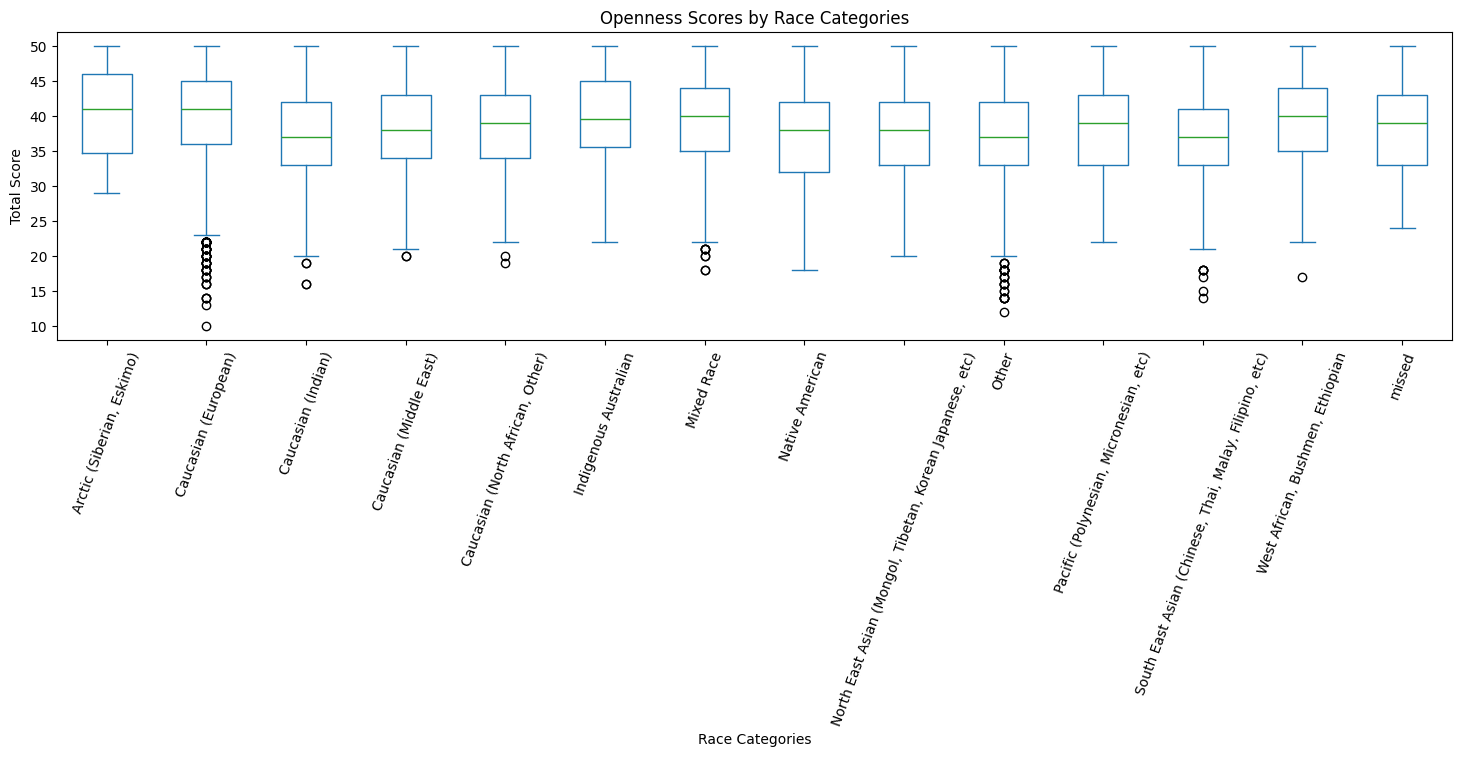

In [16]:
big5_scored_df.plot(by = 'race_cat',
                    kind='box', 
                    column=['O'], 
                    figsize=(18,4),
                    rot=70
                    )
plt.title('Openness Scores by Race Categories')
plt.ylabel('Total Score')
plt.xlabel('Race Categories')
plt.show()

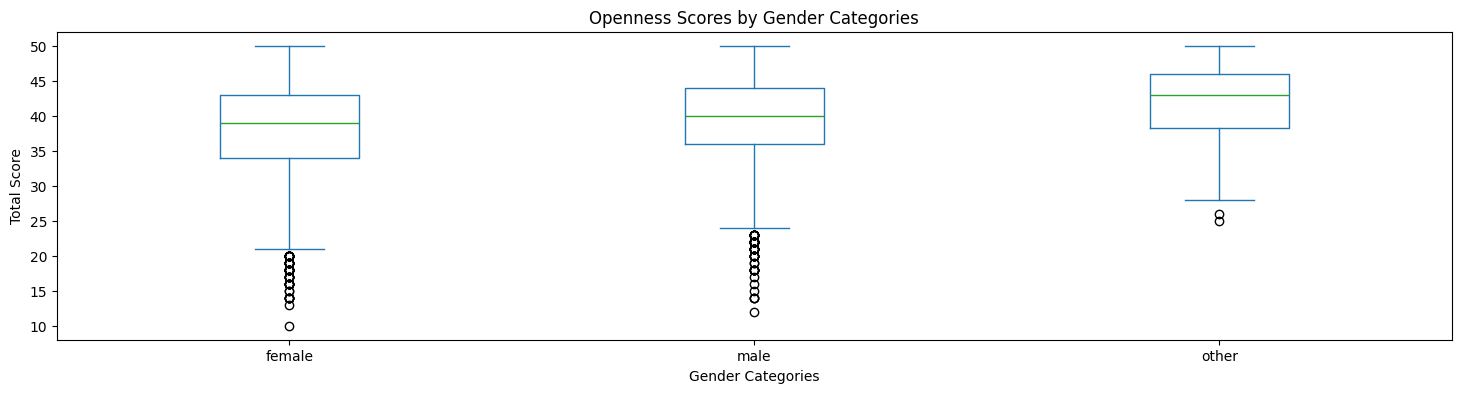

In [15]:
big5_scored_df.plot(by = 'gender_cat',
                    kind='box', 
                    column=['O'], 
                    figsize=(18,4),
                    )
plt.title('Openness Scores by Gender Categories')
plt.ylabel('Total Score')
plt.xlabel('Gender Categories')
plt.show()

As seen in the boxplots, we can see that categorizing your gender as 'other' might be an indicator of a higher score in openness. It makes sense since it does require being open to the idea of there being more than two gender categories. There does not seem to be a significant difference between female and male.

When it comes to race categories, it seems like the majority of race categories score above the minimum in openness to experience. Nevertheless, people who classify themselves as European (Caucasian) or Other are the most likely to score the lowest on openness to experience. One of the possible explanations is that people of color are generally more open to experience. However, this explanation could be biased in the sense that maybe the people who would have scored lower on openness to experience would not have taken the test in the first place.

### Agreeableness
Agreeableness measures kindness, helpfulness, and willingness to cooperate. People high in agreeableness are more trusting, affectionate, and altruistic; they generally display more prosocial behaviors than others. Then, if we were to think about people with lower levels of agreeableness, we would think of people who might not get well along with others or might be inconsiderate. We can look at some of the demographic data.

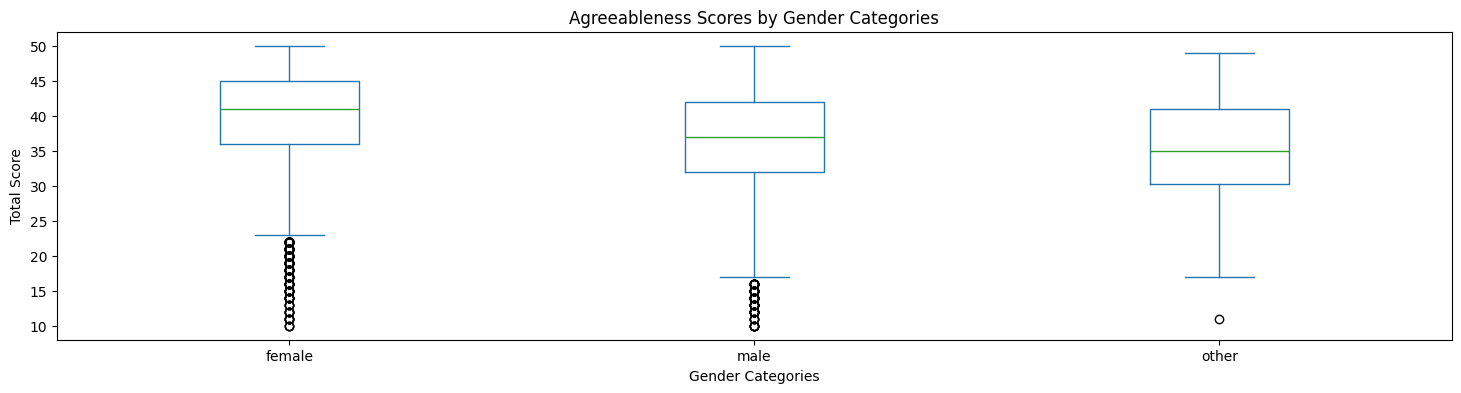

In [18]:
big5_scored_df.plot(by = 'gender_cat',
                    kind='box', 
                    column=['A'], 
                    figsize=(18,4),
                    )
plt.title('Agreeableness Scores by Gender Categories')
plt.ylabel('Total Score')
plt.xlabel('Gender Categories')
plt.show()

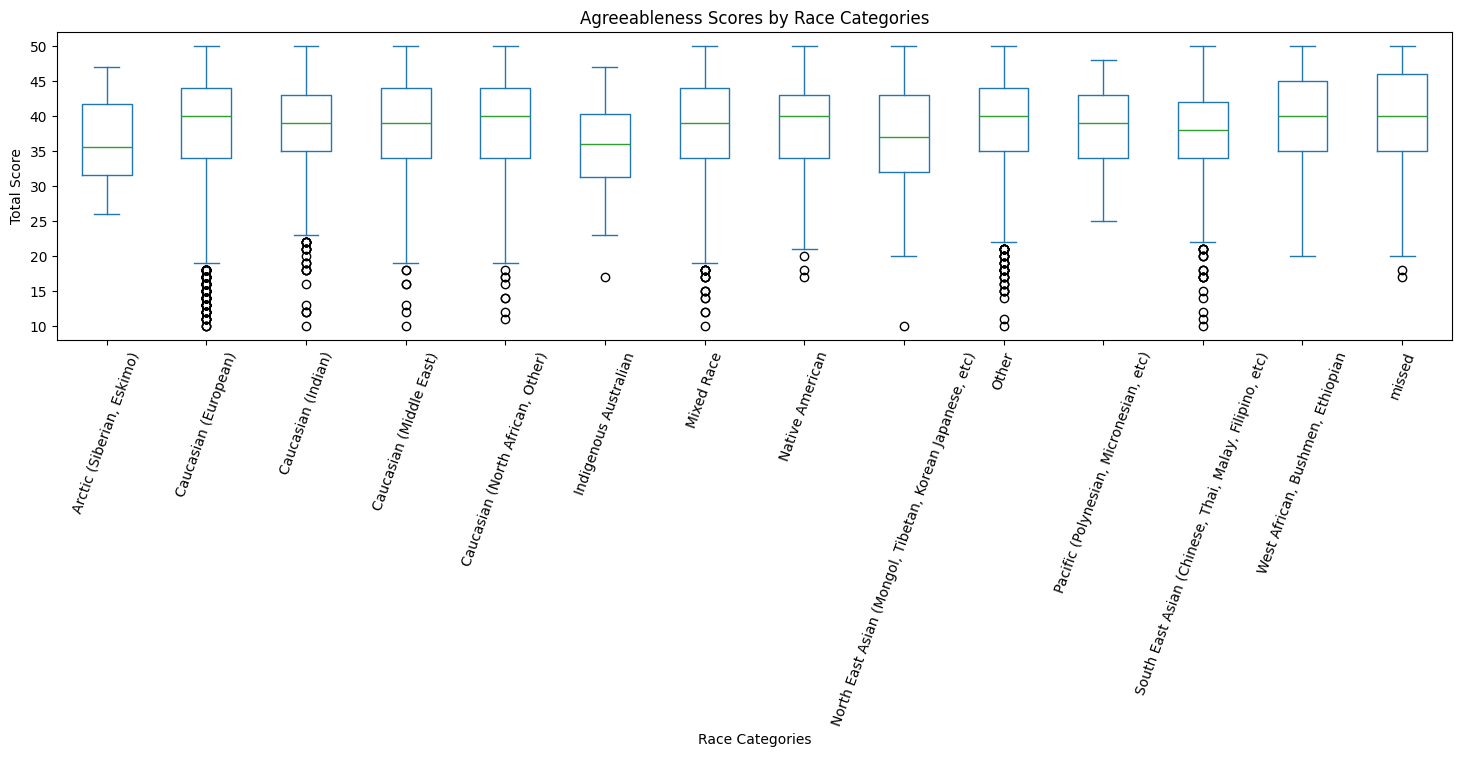

In [19]:
big5_scored_df.plot(by = 'race_cat',
                    kind='box', 
                    column=['A'], 
                    figsize=(18,4),
                    rot=70
                    )
plt.title('Agreeableness Scores by Race Categories')
plt.ylabel('Total Score')
plt.xlabel('Race Categories')
plt.show()

In the case of agreeableness, there is no demographic characteristic that seems to significantly differentiate the levels of agreeableness. Then, maybe it is the case that is difficult for people to score low on agreeableness. On the other hand, it could also be selection bias in the sample. In that sense, people with lower levels of agreeableness would not have gone on the internet to tajke a personality quiz

In general, it might be that the people who are interested in taking an online personality quiz are the ones who generally would trust to some extent the result that it suggests. Then, in some way it makes sense that there are not that many quiztakers that score the lowest possible score on openness or agreeableness.